<a href="https://colab.research.google.com/github/leodrivera/Cripto_Modelling/blob/main/Cripto_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
!pip install -r requirements.txt

# CoinGecko

In [53]:
import re
from pycoingecko import CoinGeckoAPI
from datetime import datetime

In [54]:
cg = CoinGeckoAPI()

In [55]:
def utc_to_timestamp(data):
    '''
    Get the date from the format dd/mm/yyyy and convert to timestamp
    '''
    #Get day, month, year
    data = data.split('/')
    day = re.sub('^0','',data[0])
    month = re.sub('^0','',data[1])
    year = data[2]

    #Put into the yyyy/mm/dd format
    date = datetime(int(year), int(month), int(day))

    #Remove decimal part
    
    return '{:.0f}'.format(datetime.timestamp(date))

def timestamp_to_utc(data):
    '''
    Get the date from the format timestamp, Ex: 1619913921870, and convert to format dd/mm/yyy, in a tuple
    '''
    data = datetime.fromtimestamp(int(data)/1000)

    #Get day, month, year
    day = '{:02.0f}'.format(data.day)
    month = '{:02.0f}'.format(data.month)
    year = '{:04.0f}'.format(data.year)
    hour = '{:02.0f}'.format(data.hour)
    minute = '{:02.0f}'.format(data.minute)

    return (day,month,year,hour,minute)

def adjust_date(data):
    new_dict = {}
    for categories, values in data.items():
        new_list = []
        for stamp in values:
            day,month,year,hour,minute=timestamp_to_utc(stamp[0])
            new_list.append([f'{day}/{month}/{year} {hour}:{minute}', stamp[1]])
        new_dict[categories] = new_list
    return new_dict

In [56]:
data_ini = '02/05/2021'
data_fim = '03/05/2021'

stamp_ini = utc_to_timestamp(data_ini)
stamp_fim = utc_to_timestamp(data_fim)

ethereum_data = cg.get_coin_market_chart_range_by_id(id='ethereum', vs_currency='usd', from_timestamp=stamp_ini, to_timestamp=stamp_fim)
ethereum_data_utc = adjust_date(ethereum_data)

# Alpha Vantage

In [10]:
import torch, dotenv
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from alpha_vantage.timeseries import TimeSeries

from alpha_vantage.cryptocurrencies import CryptoCurrencies

print("All libraries loaded")

All libraries loaded


In [14]:
values = dotenv.dotenv_values(".env")
KEY = values.get('key')

config = {
    "alpha_vantage": {
        "key": KEY, # Claim your free API key here: https://www.alphavantage.co/support/#api-key
        "coin": "ETH",
        "market": "CNY",
        "outputsize": "full",
        "key_close": "close (USD)",
    },
    "data": {
        "window_size": 20,
        "train_split_size": 0.80,
    }, 
    "plots": {
        "xticks_interval": 15, # show a date every 15 days
        "color_actual": "#001f3f",
        "color_train": "#3D9970",
        "color_val": "#0074D9",
        "color_pred_train": "#3D9970",
        "color_pred_val": "#0074D9",
        "color_pred_test": "#FF4136",
    },
    "model": {
        "input_size": 1, # since we are only using 1 feature, close price
        "num_lstm_layers": 2,
        "lstm_size": 32,
        "dropout": 0.2,
    },
    "training": {
        "device": "cpu", # "cuda" or "cpu"
        "batch_size": 64,
        "num_epoch": 100,
        "learning_rate": 0.01,
        "scheduler_step_size": 40,
    }
}

In [30]:
## Functions for AlphaVantage

def download_data(config):
    '''
    Download data from the alpha_vantage api

    Keyword Arguments:\t
    config: Dictionary containing the needed data\t
    '''  
    cc = CryptoCurrencies(key=KEY)
    data_cc, meta_data_cc = cc.get_digital_currency_daily(symbol=config["alpha_vantage"]["coin"], market=config["alpha_vantage"]["market"])
    data_cc = adjust_currency(data_cc, config["alpha_vantage"]["market"])

    data_date = [date for date in data_cc.keys()]
    data_date.reverse()

    data_close_price = [float(data_cc[date][config["alpha_vantage"]["key_close"]]) for date in data_cc.keys()]
    data_close_price.reverse()
    data_close_price = np.array(data_close_price)

    num_data_points = len(data_date)
    display_date_range = "from " + data_date[0] + " to " + data_date[num_data_points-1]
    print("Number data points", num_data_points, display_date_range)

    return data_date, data_close_price, num_data_points, display_date_range

def adjust_currency(data,currency_to_remove):
    '''
    Remove a certain currency from the dictionary obtained from the "get_digital_currency_daily" method and adjust the names.

    Keyword Arguments:\t
    data: Data obtained from "get_digital_currency_daily"\t
    currency_to_remove: The currency of your choice. It can be any of the currency from the list. 
    For example: currency_to_remove=CNY.
    '''
    new_dict = {}
    for date, values in data.items():
        inner_dict = {}
        for name, inner_value in values.items():
            if not currency_to_remove in name: #remove the "currency_to_remove" from the dictionary
                name = name.split()
                name = ' '.join(name[1:])
                inner_dict[name] = inner_value
        new_dict[date] = inner_dict
    return new_dict

Number data points 1000 from 2018-09-16 to 2021-06-11


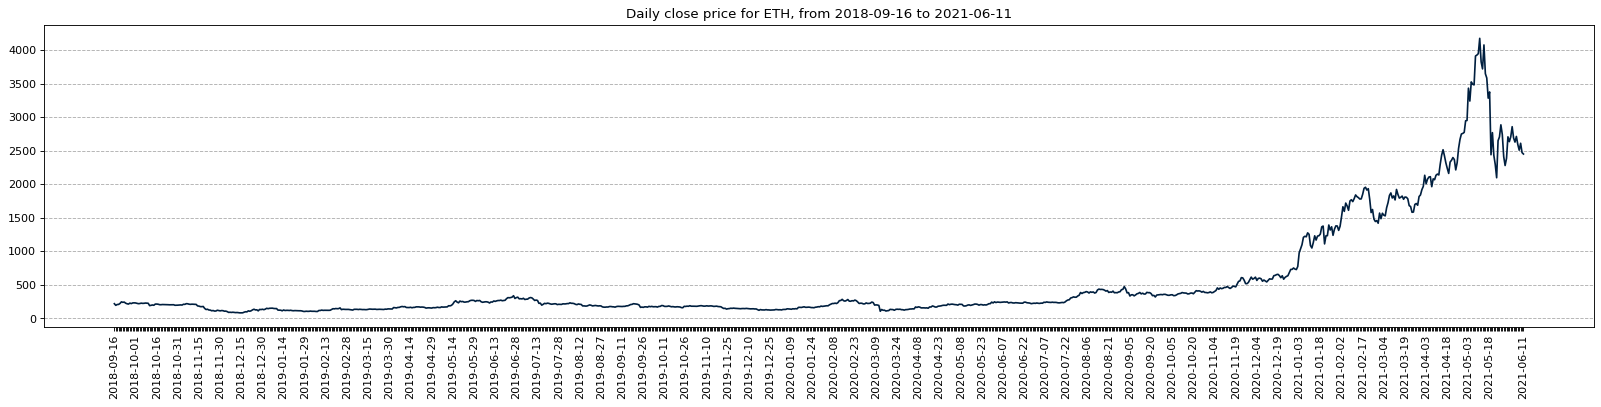

In [29]:
data_date, data_close_price, num_data_points, display_date_range = download_data(config)

# plot

fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(data_date, data_close_price, color=config["plots"]["color_actual"])
xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
x = np.arange(0,len(xticks))
plt.xticks(x, xticks, rotation='vertical')
plt.title("Daily close price for " + config["alpha_vantage"]["coin"] + ", " + display_date_range)
plt.grid(b=None, which='major', axis='y', linestyle='--')
plt.show()

Number data points 5437 from 1999-11-01 to 2021-06-10


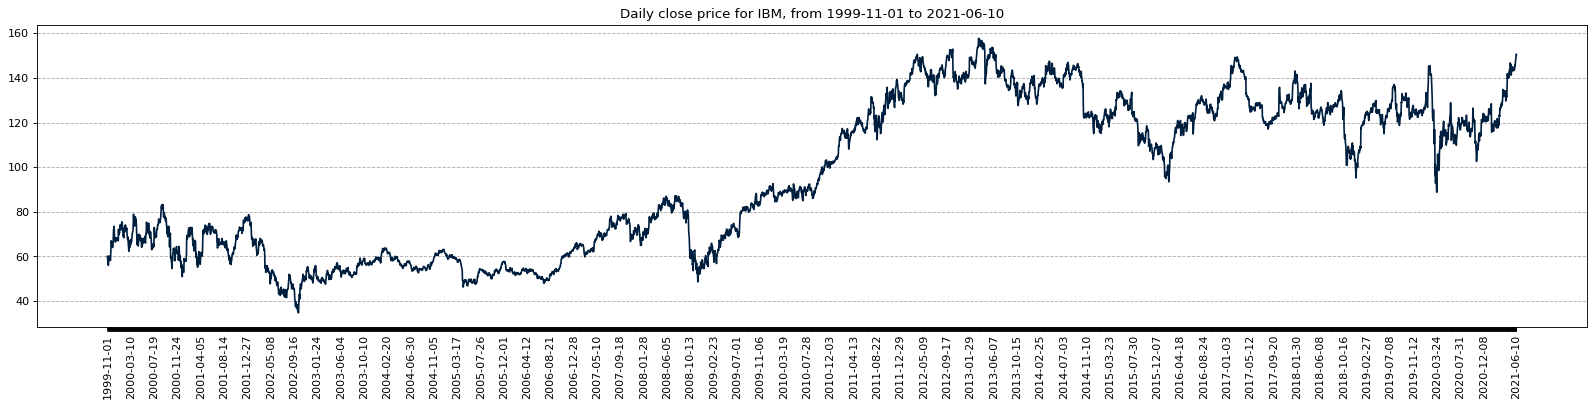

In [26]:
#Para consultar apenas
"""
def download_data(config):
    ts = TimeSeries(key=KEY)
    data, meta_data = ts.get_daily_adjusted(config["alpha_vantage"]["symbol"], outputsize=config["alpha_vantage"]["outputsize"])

    data_date = [date for date in data.keys()]
    data_date.reverse()

    data_close_price = [float(data[date][config["alpha_vantage"]["key_adjusted_close"]]) for date in data.keys()]
    data_close_price.reverse()
    data_close_price = np.array(data_close_price)

    num_data_points = len(data_date)
    display_date_range = "from " + data_date[0] + " to " + data_date[num_data_points-1]
    print("Number data points", num_data_points, display_date_range)

    return data_date, data_close_price, num_data_points, display_date_range

data_date, data_close_price, num_data_points, display_date_range = download_data(config)

# plot

fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(data_date, data_close_price, color=config["plots"]["color_actual"])
xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
x = np.arange(0,len(xticks))
plt.xticks(x, xticks, rotation='vertical')
plt.title("Daily close price for " + config["alpha_vantage"]["symbol"] + ", " + display_date_range)
plt.grid(b=None, which='major', axis='y', linestyle='--')
plt.show()
"""

In [61]:
class Normalizer():
    def __init__(self):
        self.mu = None
        self.sd = None

    def fit_transform(self, x):
        self.mu = np.mean(x, axis=(0), keepdims=True)
        self.sd = np.std(x, axis=(0), keepdims=True)
        normalized_x = (x - self.mu)/self.sd
        return normalized_x

    def inverse_transform(self, x):
        return (x*self.sd) + self.mu

# normalize
scaler = Normalizer()
normalized_data_close_price = scaler.fit_transform(data_close_price)